In [1]:
# imports

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline  

import pandas as pd
import numpy as np 
import seaborn as sns
import datetime as dt
from datetime import timedelta

In [2]:
# Data prep

df = pd.read_csv('data/COVID19_Qc_RapportINSPQ_HistoVigie.csv')
df = df.sort_values('Date', ascending=True)
df = df.drop(df.tail(1).index)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.loc[df['Date'].dt.year == 2020]
df = df.reset_index(drop=True)

# before cutoff df

first_half = df[(df['Date'] >= '2020-03-05') & (df['Date'] <= '2020-03-20')]
first_half = first_half[['Date', 'Nb_Nvx_Cas']]
first_half = first_half.reset_index(drop=True)

# after cutoff df

second_half = df[(df['Date'] >= '2020-03-20') & (df['Date'] <= '2020-04-04')]
second_half = second_half[['Date', 'Nb_Nvx_Cas']]
second_half = second_half.reset_index(drop=True)

In [3]:
def model_1(df):
    '''
    Model 1: Regression with a constant term.
    
    '''
    
    # Before and after cutoff data, split in 2 dataframes
    
    first_half = df[(df['Date'] >= '2020-03-05') & (df['Date'] <= '2020-03-20')]
    first_half = first_half[['Date', 'Nb_Nvx_Cas']].reset_index(drop=True)
    X_before = first_half['Date']
    y_before = first_half['Nb_Nvx_Cas']
    
    second_half = df[(df['Date'] >= '2020-03-20') & (df['Date'] <= '2020-04-04')]
    second_half = second_half[['Date', 'Nb_Nvx_Cas']].reset_index(drop=True)
    X_after = second_half['Date']
    y_after = second_half['Nb_Nvx_Cas']
    
    #######
    # OLS #
    #######
    
    #first half
    X = pd.DataFrame(X_before.index)
    X = sm.add_constant(X)
    y = first_half['Nb_Nvx_Cas']

    print(sm.OLS(y,X).fit(cov_type='HC2').summary())
    
    #second half
    X = pd.DataFrame(X_before.index)
    X = sm.add_constant(X)
    y = second_half['Nb_Nvx_Cas']

    print(sm.OLS(y,X).fit(cov_type='HC2').summary())
    
    
    ########
    # PLOT #
    ########
    
    
    fig, ax = plt.subplots(figsize=(8,5))

    ######### before cutoff point

    ax.scatter(X_before, y_before, color='red') # scatter plot

    X = pd.DataFrame(X_before.index)
    X = sm.add_constant(X)
    y = first_half['Nb_Nvx_Cas']

    est = sm.OLS(y,X).fit(cov_type='HC2')

    Xfit = pd.DataFrame(np.linspace(0, X.iloc[::,1].max(), len(X)))
    Xfit = sm.add_constant(Xfit)

    before_Xfit = pd.DataFrame(Xfit.iloc[::,1])
    before_yfit = pd.DataFrame(est.predict(Xfit))

    ax.plot(first_half['Date'], before_yfit, color='blue') # regression fit line

    ######### cutoff point#########

    cutoff = pd.to_datetime('2020-03-20')
    ax.axvline(cutoff, color='lime', linestyle='--')


    ######### after cutoff point
    
    ax.scatter(X_after, y_after, color='purple') # scatter plot


    X = pd.DataFrame(X_after.index)
    X = sm.add_constant(X)
    y = second_half['Nb_Nvx_Cas']

    est = sm.OLS(y,X).fit(cov_type='HC2')

    Xfit = pd.DataFrame(np.linspace(0, X.iloc[::,1].max(), len(X)))
    Xfit = sm.add_constant(Xfit)

    after_Xfit = pd.DataFrame(Xfit.iloc[::,1])
    after_yfit = pd.DataFrame(est.predict(Xfit))

    ax.plot(second_half['Date'], after_yfit, color='orange') # regression fit line

    ######### Axes, title and labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Cases')
    ax.set_title('Number of New Cases per Day (with a constant term)')
    fig.autofmt_xdate()
    fig.tight_layout()

                            OLS Regression Results                            
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     4.387
Date:                Thu, 12 Jan 2023   Prob (F-statistic):             0.0549
Time:                        19:43:30   Log-Likelihood:                -66.883
No. Observations:                  16   AIC:                             137.8
Df Residuals:                      14   BIC:                             139.3
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6544      7.022     -1.660      0.0

C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


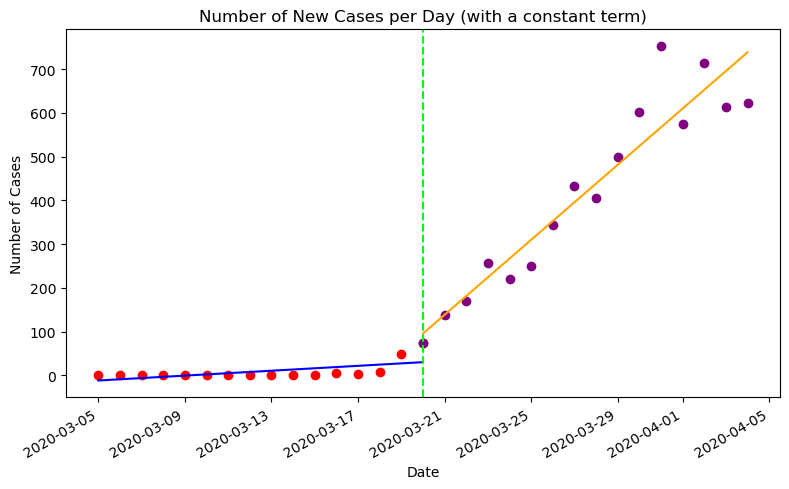

In [4]:
model_1(df)

#### Measuring the cutoff parameter's effect on data using a t-test

In [5]:
# Comparing sample values before and after the cutoff point using a t-test

pvalue = stats.ttest_ind(second_half['Nb_Nvx_Cas'].sample(n=3, random_state=1), first_half['Nb_Nvx_Cas'].sample(n=3, random_state=1)).pvalue

print()

print("Pvalue for cutoff parameter: ", pvalue)

print()

if pvalue  > 0.05:
    print("The cutoff parameter's pvalue greater is than 0.05, therefore its effect on the data is insignificant.")

else:
    print("The cutoff parameter's pvalue is less than 0.05, therefore its effect on the data is significant.")



Pvalue for cutoff parameter:  0.025011302629245186

The cutoff parameter's pvalue is less than 0.05, therefore its effect on the data is significant.


#### Interpreting results

For the first lockdown event, the best time period to choose was 2 weeks. It was not until March 11th 2020 covid cases in Quebec were being reported. This could be explained by the virus’ incubation period: it takes time for an infected person to show symptoms and get an accurate covid test result. A huge spike in new covid cases started to emerge a few days before the first lockdown. Through trial and error, time periods greater than 2 weeks resulted in poor regression results, specifically for the first half of the regression. Consequently, the plot did not accurately describe the fast rise of new cases during the days leading to the lockdown.  

The linear regression model chosen for this task was a model with an added constant term and without any polynomial features (model 1) for the following reasons. Without a constant term, the regression lines did not fit data best (the fit line deviates noticeably from data in the time period after the lockdown). When implementing a polynomial feature (model 3), model metrics indicated heavy overfitness: AIC and BIC values were lower and R2 scores got closer to 1 when compared to model 1. More precisely, model 3’s R2 score over the days before lockdown almost doubled, a major sign of overfitness. To test the effect of the cutoff parameter on data, a t-test was performed using 2 population samples: before and after the cutoff event. The test produced a pvalue of 0.025. Being less than 0.05, the null hypothesis (cutoff parameter has no effect on output) is rejected and it proves the cutoff parameters statistical significance. 


#### Other models taken in consideration

In [6]:
def model_2(df):
    
    '''
    Model 2: Regression without a constant.
    
    '''
    
    # Before and after cutoff data, split in 2 dataframes
    
    first_half = df[(df['Date'] >= '2020-03-05') & (df['Date'] <= '2020-03-20')]
    first_half = first_half[['Date', 'Nb_Nvx_Cas']].reset_index(drop=True)
    X_before = first_half['Date']
    y_before = first_half['Nb_Nvx_Cas']
    
    second_half = df[(df['Date'] >= '2020-03-20') & (df['Date'] <= '2020-04-04')]
    second_half = second_half[['Date', 'Nb_Nvx_Cas']].reset_index(drop=True)
    X_after = second_half['Date']
    y_after = second_half['Nb_Nvx_Cas']
    
    
    # first half anaylsis
    
    X = pd.DataFrame(X_before.index)
    y = y_before
        
    print(sm.OLS(y,X).fit(cov_type='HC2').summary())

    
    # second half analysis
    
    X = pd.DataFrame(X_before.index)
    y = y_after
        
    print(sm.OLS(y,X).fit(cov_type='HC2').summary())
    
    fig, ax = plt.subplots(figsize=(8,5))

    ######### before cutoff point

    ax.scatter(X_before, y_before, color='red') # scatter plot

    X = pd.DataFrame(X_before.index)
    y = first_half['Nb_Nvx_Cas']

    est = sm.OLS(y,X).fit(cov_type='HC2')

    Xfit = pd.DataFrame(np.linspace(0, X.max(), len(X)))


    before_Xfit = pd.DataFrame(Xfit)
    before_yfit = pd.DataFrame(est.predict(Xfit))

    ax.plot(first_half['Date'], before_yfit, color='blue') # regression fit line

        
    ######### cutoff point#########

    cutoff = pd.to_datetime('2020-03-20')
    ax.axvline(cutoff, color='lime', linestyle='--')


    ######### after cutoff point

    X_after = second_half['Date']
    y_after = second_half['Nb_Nvx_Cas']
    ax.scatter(X_after, y_after, color='purple') # scatter plot


    X = pd.DataFrame(X_after.index)
    y = second_half['Nb_Nvx_Cas']

    est = sm.OLS(y,X).fit(cov_type='HC2')

    Xfit = pd.DataFrame(np.linspace(0, X.max(), len(X)))

    after_Xfit = pd.DataFrame(Xfit)
    after_yfit = pd.DataFrame(est.predict(Xfit))

    ax.plot(second_half['Date'], after_yfit, color='orange') # regression fit line

        
    ######### Labels, axes and titles
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Cases')
    ax.set_title('Number of New Cases per Day (without a constant term)')
    fig.autofmt_xdate()
    fig.tight_layout()

                                 OLS Regression Results                                
Dep. Variable:             Nb_Nvx_Cas   R-squared (uncentered):                   0.428
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                              4.315
Date:                Thu, 12 Jan 2023   Prob (F-statistic):                      0.0554
Time:                        19:43:31   Log-Likelihood:                         -67.993
No. Observations:                  16   AIC:                                      138.0
Df Residuals:                      15   BIC:                                      138.8
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


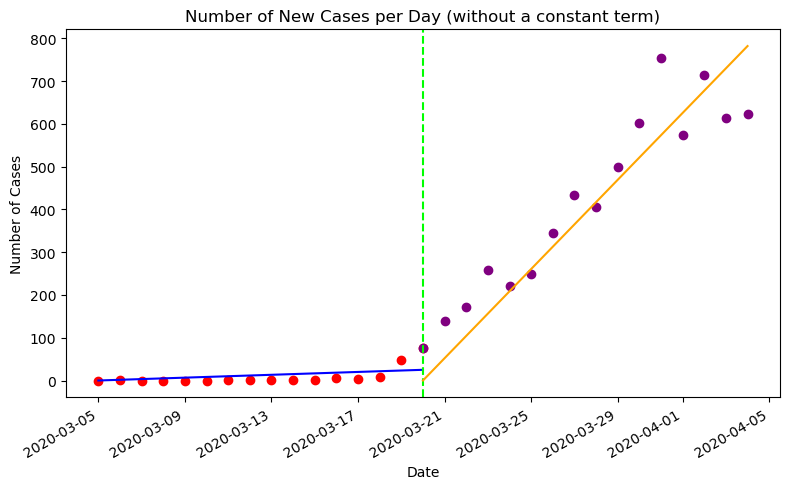

In [7]:
model_2(df)

In [8]:
def model_3(df):
    
    '''
    Model 3: Regression with a constant and a polynomial feature with degree 2.
    '''
    
    # Before and after cutoff data, split in 2 dataframes
    
    first_half = df[(df['Date'] >= '2020-03-05') & (df['Date'] <= '2020-03-20')]
    first_half = first_half[['Date', 'Nb_Nvx_Cas']].reset_index(drop=True)
    X_before = first_half['Date']
    y_before = first_half['Nb_Nvx_Cas']
    
    second_half = df[(df['Date'] >= '2020-03-20') & (df['Date'] <= '2020-04-04')]
    second_half = second_half[['Date', 'Nb_Nvx_Cas']].reset_index(drop=True)
    X_after = second_half['Date']
    y_after = second_half['Nb_Nvx_Cas']
    
    
    #######
    # OLS #
    #######
    
    # first half anaylsis
    
    X = pd.DataFrame(X_before.index)
    X = pd.concat([X,X**2], axis=1)
    X = sm.add_constant(X)
    y = y_before
        
    print(sm.OLS(y,X).fit().summary())

    
    # second half analysis
    
    X = pd.DataFrame(X_after.index)
    X = pd.concat([X,X**2], axis=1)
    X = sm.add_constant(X)
    y = y_after
        
    print(sm.OLS(y,X).fit().summary())
    
    
    ######
    #PLOT#
    ######
    
    fig, ax = plt.subplots(figsize=(8,5))
    
    ######### before cutoff point

    ax.scatter(X_before, y_before, color='red') # scatter plot

    X = pd.DataFrame(X_before.index)
    X = pd.concat([X,X**2], axis=1)
    X = sm.add_constant(X)
    y = first_half['Nb_Nvx_Cas']

    est = sm.OLS(y,X).fit()

    Xfit = pd.DataFrame(np.linspace(0, X.iloc[::,1].max(), len(X)))
    Xfit = pd.concat([Xfit,Xfit**2], axis=1)
    Xfit= sm.add_constant(Xfit)

    before_Xfit = pd.DataFrame(Xfit)
    before_yfit = pd.DataFrame(est.predict(Xfit))

    ax.plot(first_half['Date'], before_yfit, color='blue') # regression fit line

        
    ######### cutoff point#########

    cutoff = pd.to_datetime('2020-03-20')
    ax.axvline(cutoff, color='lime', linestyle='--')


    ######### after cutoff point

    X_after = second_half['Date']
    y_after = second_half['Nb_Nvx_Cas']
    ax.scatter(X_after, y_after, color='purple') # scatter plot


    X = pd.DataFrame(X_after.index)
    X = pd.concat([X,X**2], axis=1)
    X = sm.add_constant(X)
    y = second_half['Nb_Nvx_Cas']

    est = sm.OLS(y,X).fit()

    Xfit = pd.DataFrame(np.linspace(0, X.iloc[::,1].max(), len(X)))
    Xfit = pd.concat([Xfit,Xfit**2], axis=1)
    Xfit= sm.add_constant(Xfit)

    after_Xfit = pd.DataFrame(Xfit.iloc[::,1])
    after_yfit = pd.DataFrame(est.predict(Xfit))

    ax.plot(second_half['Date'], after_yfit, color='orange') # regression fit line

        
    ######### Labels, axes and titles
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Cases')
    ax.set_title('Number of New Cases per Day (with constant term and poly degree 2)')
    fig.autofmt_xdate()
    fig.tight_layout()

C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Aley\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     17.21
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           0.000222
Time:                        19:43:31   Log-Likelihood:                -60.603
No. Observations:                  16   AIC:                             127.2
Df Residuals:                      13   BIC:                             129.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9571      7.884      1.263      0.2

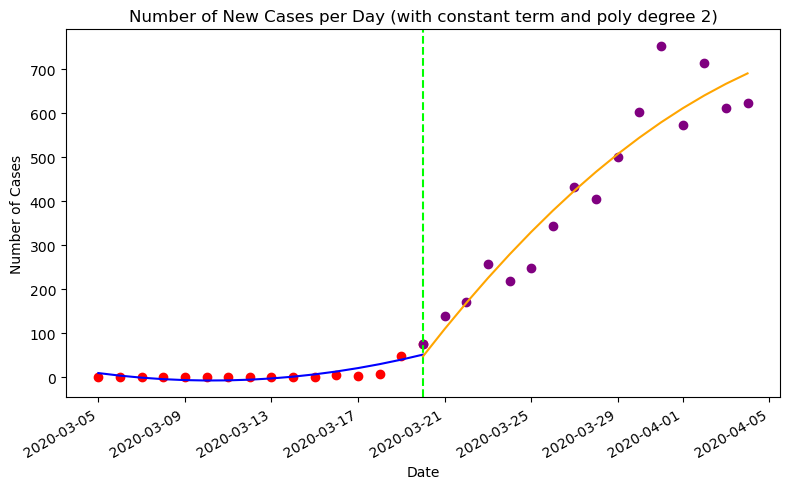

In [9]:
model_3(df)